# RHF 偶极矩计算

我们在曾经的文档中，已经讨论了解析 RHF 的公式表达式了；但我们尚未系统地推导偶极矩的解析梯度。这一节我们系统地推导 RHF 偶极矩，并且确立以后文档的风格。

我们之前说到，任何导数通常都可以分为 Skeleton 导数与 U 导数；但对于 RHF 的一阶梯度响应性质，U 导数可以通过巧妙的数学方式避免。因此，我们只需要学会 Skeleton 导数的求取就可以完成 RHF 的偶极矩计算。

## 准备工作与符号定义

我们假定以后会始终引入如下的库函数和设定：

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

以后的文档可能会在正文前，花大量代码进行准备工作。这些代码可能会非常相似，但有细微的变化。譬如

- 量化方法上，有 RHF 自洽场、GGA 自洽场、GGA 非自洽、MP2 后自洽、bDH 后自洽、xDH 后自洽型；

- 一阶梯度上，有电场导数、核坐标导数；

- 二阶梯度上，有核坐标二阶导数、电场二阶导数、核坐标与电场混合导数。

读者可能需要注意到这些差距。

其中一部分变量是我们以后也会经常用到的、物理意义始终不变的变量：

- `mol` 分子实例，类型为 `gto.Mole`

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

- `nao` $n_\mathrm{AO}$ 原子轨道数量 (基组数量)；

- `nmo` $n_\mathrm{MO}$ 分子轨道数量，被定义为与原子轨道数量相同； 

- `nocc` $n_\mathrm{occ}$ 占据轨道数量，在闭壳层中被定义为电子数的一半；

- `nvir` $n_\mathrm{vir}$ 非占轨道数量，$n_\mathrm{MO} - n_\mathrm{occ}$；

- `so`, `sv`, `sa` 分别为占据、非占、全部轨道的分割。

In [3]:
nmo, nao, natm = mol.nao, mol.nao, mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)

- `H_0_ao` $h_{\mu \nu}$ 原子轨道 Hamiltonian Core 矩阵；

- `S_0_ao` $S_{\mu \nu}$ 原子轨道重叠矩阵；

- `eri0_ao` $(\mu \nu | \kappa \lambda)$ 原子轨道 ERI 积分。

In [4]:
H_0_ao = mol.intor("int1e_kin") + mol.intor("int1e_nuc")
S_0_ao = mol.intor("int1e_ovlp")
eri0_ao = mol.intor("int2e")

我们暂且先定义下述非普遍的自洽场过程 `diph` 是通过 `DipoleSCF` 类实现的：

In [5]:
from pyxdh.DerivOnce import DipoleSCF
diph = DipoleSCF({"scf_eng": scf.RHF(mol)})

经过自洽场计算后的量有 (不论是 GGA 或是 RHF)：

- `C` $C_{\mu p}$ 轨道系数；

- `Co` $C_{\mu i}$, `Cv` $C_{\mu a}$ 分别为占据轨道系数、非占轨道系数

- `e` $\varepsilon_p$ 轨道能；

- `eo` $\varepsilon_i$, `ev` $\varepsilon_a$ 分别为占据轨道能、非占轨道能；

- `D` $D_{\mu \nu}$ 原子轨道密度矩阵。

In [6]:
C = diph.C
Co, Cv = C[:, so], C[:, sv]
e = diph.e
eo, ev = e[so], e[sv]
D = diph.D

- `F_0_ao` $F_{\mu \nu}$ 原子轨道 Fock 矩阵 (需要留意 Fock 矩阵与上述原子轨道矩阵不同，是与分子轨道系数相关的量)；

In [7]:
F_0_ao = diph.F_0_ao

下面是依靠分子轨道方能定义的量：

- `H_0_mo` $h_{pq}$ 分子轨道 Hamiltonian Core 矩阵；

- `S_0_mo` $S_{pq}$ 分子轨道重叠矩阵；

- `F_0_mo` $F_{pq}$ 分子轨道 Fock 矩阵；

- `eri0_mo` $(pq | rs)$ 分子轨道 ERI 积分。

In [8]:
H_0_mo = diph.H_0_mo
S_0_mo = diph.S_0_mo
F_0_mo = diph.F_0_mo
eri0_mo = diph.eri0_mo

其余的变量通常是与梯度有关的量，这些变量名可能会在以后介绍。

在继续进行文档之前，我们先定义偶极矩的数值梯度辅助类 `DipoleDerivGenerator` 实例 `dipn`：

In [9]:
def dipn_generator(component, interval):
    scf_eng = scf.RHF(mol)
    def get_hcore(mol=mol):
        return scf.rhf.get_hcore(mol) - interval * mol.intor("int1e_r")[component]
    scf_eng.get_hcore = get_hcore
    config = {
        "scf_eng": scf_eng,
    }
    return DipoleSCF(config)

In [10]:
dipn = DipoleDerivGenerator(dipn_generator)

## Hamiltonian Core Skeleton 导数

### 解析梯度

我们在普通的 RHF 计算中，Hamiltonian Core 是动能与原子核静电势能导出量之和：

$$
\begin{align}
\hat h = \hat t + \hat v_\mathrm{nuc} &= - \frac{1}{2} \frac{\partial^2}{\partial t^2} - \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |} \quad (\textsf{Einsum form}) \\
&= - \frac{1}{2} \sum_r \frac{\partial^2}{\partial t^2} - \sum_M \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |} \quad (\textsf{Ordinary form})
\end{align}
$$

若不作更多说明，我们以后通常用上面的作者所定义的 Einsum Form 进行公式描述 (这与正统的 Einstein Summation 近乎完全不同)。但可能会非常不直观，因此读者可能需要习惯这些记号，或者自己创立自己的公式符号体系。

我们对上面的表达式作补充说明。第一项的 $t$ 是坐标分量，而非 $\hat t$ 的动能算符一意。第二项的 $M$ 表示原子；我们知道对于单个电子而言，静电势能是各个原子对其势能的和；因此对 $M$ 求和。而 $\hat h$ 事实上是与电子坐标 $\boldsymbol{r}$ 有关的算符，因此不需要对 $\boldsymbol{r}$ 进行求和。

但上述量与电场完全无关。我们提到过，偶极矩是分子在外加电场下的能量微扰表征。这个外加电场可以附加在 Hamiltonian Core 上，因此我们这篇文档讨论的 Hamiltonian Core 实际上是

$$
\begin{align}
\hat h (F_t) &= - \frac{1}{2} \frac{\partial^2}{\partial t^2} - \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |} - F_t \quad (\textsf{Einsum form}) \\
&= - \frac{1}{2} \sum_r \frac{\partial^2}{\partial t^2} - \sum_M \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |} - \sum_t F_t t \quad (\textsf{Ordinary form})
\end{align}
$$

那么，其对应的 Hamiltonian Core 矩阵为

$$
h_{\mu \nu} (F_t) = \langle \mu | - \frac{1}{2} \frac{\partial^2}{\partial t^2} - \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |} | \nu \rangle - F_t \langle \mu | t | \nu \rangle
$$

那么，

$$
\frac{\partial h_{\mu \nu} (F_t)}{\partial F_t} = - \langle \mu | t | \nu \rangle = - t_{\mu \nu}
$$

对于上述表达式，我们也会简写为

$$
h_{\mu \nu}^t = \frac{\partial h_{\mu \nu}}{\partial F_t} = - t_{\mu \nu}
$$

上述的矩阵将会是维度 $(t, \mu, \nu)$ 的张量 `H_1_ao`，其在 PySCF 中可以通过如下方式生成：

In [11]:
H_1_ao = - mol.intor("int1e_r")
H_1_ao.shape

(3, 22, 22)

符号 `H_1_ao` 相对于 `H_0_ao` 而言，改变的 1 代表一阶 Skeleton 导数 $h_{\mu \nu}^\mathbb{A}$；而对于电场导数，它就特例化为 $h_{\mu \nu}^t$。

这个符号也会用在所有以 `DerivOnce` 为基类的类的实例中，譬如偶极计算实例 `diph` 的 `H_1_ao` property 就可以导出 $h_{\mu \nu}^t$。我们可以验证上面计算得到的 `H_1_ao` 与 `DipoleSCF` 给出的 `H_1_ao` 是相等的：

In [12]:
np.allclose(H_1_ao, diph.H_1_ao)

True

### 数值梯度

我们可以通过 `dipn` 来辅助作三点差分所给出的 `nd_H_0_ao` $\partial_{F_t} h_{\mu \nu}$：

In [13]:
nd_H_0_ao = NumericDiff(dipn, lambda diph: diph.H_0_ao).derivative
nd_H_0_ao.shape

(3, 22, 22)

上式中的 `nd_H_0_ao` 可以用来验证我们所计算的 $h_{\mu \nu}^t$ `H_1_ao`；之所以起名 `nd_H_0_ao`，是因为它是 `H_0_ao` $h_{\mu \nu}$ 的数值导数 (Numerical Derivative)。

我们以后通常下述的图像来表明方才所计算的密度矩阵梯度是正确的。

下图表示的是误差的直方图。其中，

- 蓝色条表示数值矩阵值与解析矩阵值之间的误差，橙色条表示数值导数矩阵本身的值。

- 横坐标表示矩阵数值大小，纵坐标表示处在某一区间的矩阵数值数量。

因此，若蓝色条越靠左，表明数值矩阵与解析矩阵在绝对误差上越小；蓝色与橙色条差距越大，表明数值矩阵与解析矩阵在相对误差上越小。

<IPython.core.display.Javascript object>


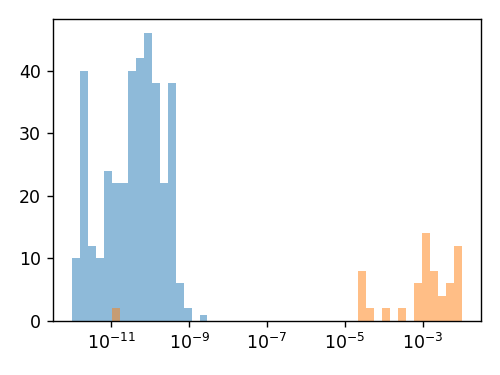

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_H_0_ao - H_1_ao).ravel(), bins=np.logspace(np.log10(1e-12),np.log10(1e-2), 50), alpha=0.5)
ax.hist(abs(nd_H_0_ao).ravel(), bins=np.logspace(np.log10(1e-12),np.log10(1e-2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

这表明，我们计算所得到的解析梯度 `H_1_ao` $h_{\mu \nu}^t$ 确实地与数值梯度非常接近 `nd_H_0_ao`。

我们以后对于每一个可以求数值梯度验证的量，都会进行上述图像的绘制。尽管在当前的例子中，解析矩阵与数值矩阵的差距非常小，以至于在 `np.allclose` 函数下这两个矩阵也会被认为是近似相等的：

In [15]:
np.allclose(H_1_ao, nd_H_0_ao)

True

但在以后更为广泛的情况中，解析与数值矩阵未必能通过 `np.allclose` 的判断；因此需要绘制上述图像来确认。一般来说，只要蓝色条 (解析与数值矩阵之差) 绝大部分元素小于 $10^{-6}$、且与橙色条 (数值矩阵) 能明显区分，一般就可以了；因为矩阵最后都需要经过运算才能得到最终的偶极矩或分子力，在计算的过程中这些误差多少会被消除。

### 分子轨道的 Skeleton 导数

我们已经介绍了原子轨道下的 Skeleton 导数；分子轨道的 Skeleton 导数可以用下式简单地给出：

$$
h_{pq}^t = C_{\mu p} h_{\mu \nu}^t C_{\nu q}
$$

In [16]:
H_1_mo = np.einsum("up, tuv, vq -> tpq", C, H_1_ao, C)
H_1_mo.shape

(3, 22, 22)

可以验证在 `DipoleSCF` 中实现的 `H_1_mo` property 与上述输出是相同的：

In [17]:
np.allclose(H_1_mo, diph.H_1_mo)

True

但是，就如上一篇文档所言，

$$
\frac{\partial h_{pq}}{\partial F_t} \neq h_{pq}^t
$$

我们不妨先生成数值导数 `deriv_H_0_mo` $\partial_{F_t} h_{pq}$：

In [18]:
nd_H_0_mo = NumericDiff(dipn, lambda diph: diph.H_0_mo).derivative
nd_H_0_mo.shape

(3, 22, 22)

我们尝试绘制 `deriv_H_0_mo` $\partial_{F_t} h_{pq}$ 与 `H_1_mo` 的差距 $h_{pq}^t$：

<IPython.core.display.Javascript object>


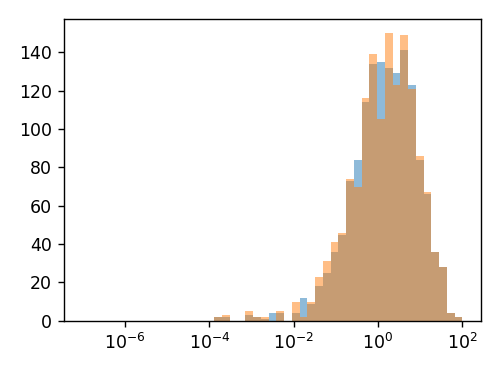

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_H_0_mo - H_1_mo).ravel(), bins=np.logspace(np.log10(1e-7),np.log10(1e2), 50), alpha=0.5)
ax.hist(abs(nd_H_0_mo).ravel(), bins=np.logspace(np.log10(1e-7),np.log10(1e2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

可见，$\partial_{F_t} h_{pq}$ 与 $h_{pq}^t$ 之间相差巨大。关于这一点，我们会在以后进一步陈述。

## 重叠矩阵 Skeleton 导数

我们回顾重叠矩阵的定义：

$$
S_{\mu \nu} = \langle \mu | \nu \rangle = \int \phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

该矩阵仅仅与电荷坐标与原子核坐标有关，与电场量无关。因此，

$$
\frac{\partial S_{\mu \nu}}{\partial F_t} = S_{\mu \nu}^t = 0
$$

事实上，`DipoleSCF` 类给出的 `S_1_ao` $S_{\mu \nu}^t$ 就被定义为了标量 0。

In [20]:
diph.S_1_ao

0

但需要注意，$S_{\mu \nu}^t$ 从定义上并非是标量，而是维度为 $(t, \mu, \nu)$ 的张量，其中每个元素的值为零。数值导数 `nd_S_0_ao` $\partial_{F_t} S_{\mu \nu}$ 的结果如下：

In [21]:
nd_S_0_ao = NumericDiff(dipn, lambda diph: diph.S_0_ao).derivative
nd_S_0_ao.shape

(3, 22, 22)

其绝对值最大的元素就是零：

In [22]:
np.abs(nd_S_0_ao).max()

0.0

对应地，分子轨道下的重叠矩阵导数 $S_{pq}^t$ 也为零：

In [23]:
diph.S_1_mo

0

<div class="alert alert-info">

**任务 (1)**

我们方才提及，

$$
\frac{\partial h_{pq}}{\partial F_t} \neq h_{pq}^t
$$

这类等式普遍来说是不成立的，但

$$
\frac{\partial S_{pq}}{\partial F_t} = S_{pq}^t = 0
$$

请说明上述等式成立的原因。

</div>

## ERI 积分 Skeleton 导数

我们回顾 ERI 积分的定义：

$$
(\mu \nu | \kappa \lambda) = \int \phi_\mu (\boldsymbol{r}_1) \phi_\nu (\boldsymbol{r}_1) \frac{1}{| \boldsymbol{r}_1 - \boldsymbol{r}_2 |} \phi_\kappa (\boldsymbol{r}_2) \phi_\lambda (\boldsymbol{r}_2) \, \mathrm{d} \boldsymbol{r}_1 \, \mathrm{d} \boldsymbol{r}_2
$$

我们会发现上述量也仅仅是关于电荷坐标与原子核坐标的量，因此，其 Skeleton 导数

$$
\frac{\partial (\mu \nu | \kappa \lambda)}{\partial F_t} = (\mu \nu | \kappa \lambda)^t = 0
$$

上述量储存在 `diph` 的 `eri1_ao` property 中：

In [24]:
diph.eri1_ao

0

那么，其对应的分子轨道 Skeleton 导数也为零：

In [25]:
diph.eri1_mo

0

<div class="alert alert-info">

**任务 (2)**

尽管 $S_{pq}^t = 0$ 且 $(\mu \nu | \kappa \lambda)^t = 0$，但 $\partial_{F_t} S_{pq} = S_{pq}^t = 0$ 这样的结论不能直接套用到 $(pq|rs)$ 上。请用程序验证

$$
\frac{\partial (pq|rs)}{\partial F_t} \neq (pq|rs)^t = 0
$$

</div>

## 电子态能量导数

### 解析导数

我们知道，总能量可以分为电子能量 $E_\mathrm{elec}$ 与原子核能量 $E_\mathrm{nuc}$。我们先回顾电子能量的计算过程：

$$
E_\mathrm{elec} = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}
$$

我们通过链式法则，应当能知道：

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial F_t} &=
\frac{\partial h_{\mu \nu}}{\partial F_t} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} \frac{\partial (\mu \nu | \kappa \lambda)}{\partial F_t} D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} \frac{\partial (\mu \kappa | \nu \lambda)}{\partial F_t} D_{\kappa \lambda} \\
&\quad + F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial F_t} 
\end{align}
$$

其中，上式的第一行是 Skeleton 导数的集合，而第二行是与分子轨道有关的导数，即 U 导数的集合。

<div class="alert alert-info">

**任务 (3)**

上式的第一行是非常显然能导出的；请说明第二行的导出过程。

</div>

但是，上式的四项中，除了第一项之外，其余三项都为零。

<div class="alert alert-info">

**任务 (4)**

上式第二、第三项中 Skeleton 导数 $(\mu \nu | \kappa \lambda)^t$ 为零，因此值为零；这是很容易理解的。

请证明第四项也为零。

</div>

因此，

$$
\frac{\partial E_\mathrm{elec}}{\partial F_t} = h_{\mu \nu}^t D_{\mu \nu}
$$

我们将变量 `dip_elec` 定义为 $\partial_{F_t} E_\mathrm{elec}$：

In [26]:
dip_elec = np.einsum("tuv, uv -> t", H_1_ao, D)
dip_elec

array([ -0.99981,  -0.65982, -24.86113])

### 数值导数

我们可以用 PySCF 的 `energy_elec` method 求出电子态能量并作数值导数：

In [27]:
nd_E_elec = NumericDiff(dipn, lambda diph: diph.scf_eng.energy_elec()[0]).derivative
nd_E_elec

array([ -0.99981,  -0.65982, -24.86113])

我们会发现，数值导数与解析导数的值近乎一致：

In [28]:
np.allclose(dip_elec, nd_E_elec)

True

<div class="alert alert-info">

**程序用法**

尽管我们曾经提到过要用 pyplot 绘图查看数值导数与解析导数的差异，但这是针对中间计算矩阵而用的，因为中间计算矩阵即使误差较大也未必会对结果带来影响。

但对作为最终结果的贡献项，我们仍然要用 np.allclose 核验。np.allclose 是更为严苛的核验方式。

</div>

我们 [曾经](../numdiff/num_dip.ipynb) 用较为物理的方式，提到过计算电子云对偶极矩的贡献大小。这里我们用了解析导数的方式对其作呈现；两者的推导结论是相同的。

## 原子核互斥能导数

原子核互斥能对偶极矩的贡献也非常重要；但我们不作更多说明。其推导参考 [之前的文档](../numdiff/num_dip.ipynb)；我们定义该贡献为 `dip_nuc`：

$$
\frac{\partial E_\mathrm{nuc}}{\partial F_t} = Z_A A_t
$$

In [29]:
dip_nuc = np.einsum("A, At -> t", mol.atom_charges(), mol.atom_coords())
dip_nuc

array([ 1.88973,  1.32281, 24.56644])

那么，最后我们将两个偶极矩贡献量相加，得到 `dip_total`

$$
\frac{\partial E}{\partial F_t} = \frac{\partial E_\mathrm{elec}}{\partial F_t} + \frac{\partial E_\mathrm{nuc}}{\partial F_t}
$$

In [30]:
dip_total = dip_elec + dip_nuc
dip_total

array([ 0.88992,  0.66299, -0.29469])

需要留意，该总和量暂时不能通过求数值导数获得；这是因为在 PySCF 中或 pyxdh 中，核坐标导数没有写为 $F_t$ 的因变量。因此，我们看到的对总能量的导数会是电子态能量导数；这是错误的。

In [31]:
nd_eng = NumericDiff(dipn, lambda diph: diph.eng).derivative
nd_eng  ## Wrong total energy derivative to get dipole!

array([ -0.99981,  -0.65982, -24.86113])

最后，我们声明我们的计算结果与 PySCF 所给出的结果完全相同：

In [32]:
dip_total_pyscf = diph.scf_eng.dip_moment(unit="A.U.", verbose=0)
dip_total_pyscf

array([ 0.88992,  0.66299, -0.29469])

In [33]:
np.allclose(dip_total, dip_total_pyscf)

True

## 参考任务解答

### 任务 (1)

正如上一篇文档 [任务 (2)](skeleton_and_U.ipynb#任务-(2)) 所言，由于 $S_{pq} = \delta_{pq}$，因此 $S_{pq}$ 与外加电场 $F_t$ 完全无关；故 $\partial_{F_t} S_{pq}$ 为零。

### 任务 (2)

计算 $(pq|rs)$ 的方法，在 `diph` 中是 `eri0_mo` property。我们将 $\partial_{F_t} (pq|rs)$ 记为 `nd_eri0_mo`：

In [34]:
nd_eri0_mo = NumericDiff(dipn, lambda diph: diph.eri0_mo).derivative
nd_eri0_mo.shape

(3, 22, 22, 22, 22)

该张量显然不是零张量；我们能发现，绝大多数值处于 $10^{-2}$ 数量级。

<IPython.core.display.Javascript object>


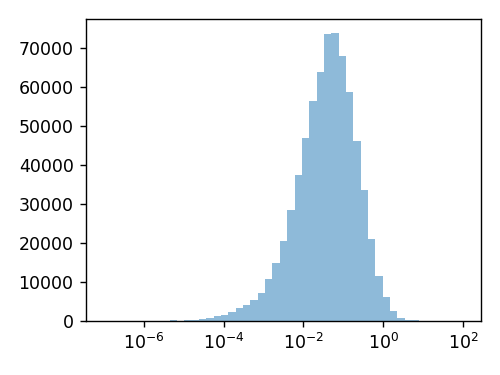

In [35]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_eri0_mo).ravel(), bins=np.logspace(np.log10(1e-7),np.log10(1e2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

### 任务 (3)

$$
E_\mathrm{elec} = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}
$$

上式除开 Skeleton 导数之外，就是所有对密度矩阵 $D_{\mu \nu}$ 或 $D_{\kappa \lambda}$ 的导数贡献了：

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial F_t} \leftarrow h_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial F_t} + \frac{1}{2} \frac{\partial D_{\mu \nu}}{\partial F_t} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) \frac{\partial D_{\kappa \lambda}}{\partial F_t} - \frac{1}{4} \frac{\partial D_{\mu \nu}}{\partial F_t} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) \frac{\partial D_{\kappa \lambda}}{\partial F_t}
\end{align}
$$

上式的向左箭头意指贡献而非等价。我们指出，上式的第 2、3 项是相等的。我们先用普通的求和形式写出上面的第 2、3 项：

$$
\begin{align}
\textsf{Term 2}&: \, \frac{1}{2} \sum_{\mu \nu \kappa \lambda} \frac{\partial D_{\mu \nu}}{\partial F_t} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} \\
\textsf{Term 3}&: \, \frac{1}{2} \sum_{\mu \nu \kappa \lambda} D_{\mu \nu} (\mu \nu | \kappa \lambda) \frac{\partial D_{\kappa \lambda}}{\partial F_t}
\end{align}
$$

既然是求和，那么角标符号就不再重要。我们将第 3 项的角标 $(\mu, \nu, \kappa, \lambda)$ 替换为 $(\kappa, \lambda, \mu, \nu)$，得到

$$
\textsf{Term 3}: \, \frac{1}{2} \sum_{\kappa \lambda \mu \nu} D_{\kappa \lambda} (\kappa \lambda | \mu \nu) \frac{\partial D_{\mu \nu}}{\partial F_t}
$$

这里需要利用到 ERI 积分的对称性

$$
(\kappa \lambda | \mu \nu) = (\mu \nu | \kappa \lambda)
$$

就得到了与第 2 项完全一模一样的结果。

对于第 4、5 项亦作同样处理，得到

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial F_t} &\leftarrow h_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial F_t} + \frac{\partial D_{\mu \nu}}{\partial F_t} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{2} \frac{\partial D_{\mu \nu}}{\partial F_t} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} \\
&= \big( h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{2} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} \big) \frac{\partial D_{\mu \nu}}{\partial F_t} \\
&= F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial F_t}
\end{align}
$$

关于 RHF 下 Fock 矩阵的形式，读者可能需要自行回忆一下。我们在此用程序表明 RHF 下，

$$
F_{\mu \nu} = h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{2} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}
$$

In [36]:
np.allclose(
    + H_0_ao
    + np.einsum("uvkl, kl -> uv", eri0_ao, D)
    - 0.5 * np.einsum("ukvl, kl -> uv", eri0_ao, D),
    F_0_ao
)

True

### 任务 (4)

我们继续对上一个任务中没有化简完的 $\partial_{F_t} D_{\mu \nu}$ 作展开。我们知道，密度矩阵从定义上是占据轨道矩阵的缩并：

$$
D_{\mu \nu} = 2 C_{\mu i} C_{\nu i}
$$

那么，根据链式法则，有

$$
\frac{\partial D_{\mu \nu}}{\partial F_t} = \frac{\partial C_{\mu i}}{\partial F_t} C_{\nu i} + C_{\mu i} \frac{\partial C_{\nu i}}{\partial F_t}
$$

根据 U 矩阵定义

$$
\frac{\partial C_{\mu p}}{\partial \mathbb{A}} = C_{\mu m} U_{mp}^\mathbb{A}
$$

代入链式法则导出式，得到

$$
\frac{\partial D_{\mu \nu}}{\partial F_t} = 2 \big( C_{\mu m} U_{mi}^t C_{\nu i} + C_{\mu i} C_{\nu m} U_{mi}^t \big)
$$

上式中出现了看上去非常相似的两项；但这两项并非是相等，而是互为转置。我们以后会用 `U_1` 表示 U 矩阵 (但 U 矩阵分为安全与非安全的，但现在还不需要了解这些)：

In [37]:
U_1 = diph.U_1

用 np.allclose 可以验证其互为转置关系：

In [38]:
np.allclose(
    np.einsum("um, tmi, vi -> tuv", C, U_1[:, sa, so], Co),
    np.einsum("ui, vm, tmi -> tuv", Co, C, U_1[:, sa, so]).swapaxes(-1, -2)
)

True

将 $\partial_{F_t} D_{\mu \nu}$ 结果代入，得到

$$
\frac{\partial E_\mathrm{elec}}{\partial F_t} \leftarrow F_{\mu \nu} 2 \frac{\partial D_{\mu \nu}}{\partial F_t} = 4 (F_{mi} + F_{im}) U_{mi}^t = 2 F_{mi} U_{mi}^t
$$

我们将上述矩阵分为两部分考虑。若 $m$ 处在非占轨道，则

$$
\frac{\partial E_\mathrm{elec}}{\partial F_t} \leftarrow 4 F_{ai} U_{ai}^t = 0
$$

这是因为从 RHF 定义上，$F_{ai} = 0$。

剩下的部分是 $m$ 处于占据轨道，则

$$
\frac{\partial E_\mathrm{elec}}{\partial F_t} \leftarrow 4 F_{ji} U_{ji}^t = 2 \big( F_{ij} U_{ij}^t + F_{ji} U_{ji}^t \big) = 2 F_{ij} (U_{ij}^t + U_{ji}^t) = 0
$$

上式的

- 第一个等号利用到的是对 $(i, j)$ 求和等价于对 $(j, i)$ 求和，因此可以互换 $(i, j)$ 角标而不影响结果；

- 第二个等号利用到的是 $F_{ij} = F_{ji}$ 即 Fock 矩阵是对称矩阵；

- 第三个等号利用到的是 $U_{ij}^t + U_{ji}^t = - S_{ij}^t = 0$，其更为一般的结论 $S_{pq}^\mathbb{A} + U_{pq}^\mathbb{A} + U_{qp}^\mathbb{A} = 0$ 我们已经在上一节的任务中证明了。